# The FDMT with non power of 2 channels
The baseline FDMT needs to process data with a number of channels that is not a power of 2. In fact, you need to do that if you telescopes makes non-power-of-2 channels fullstop. Why is a power of 2 important? Ahah, my friend. How convenenient that you ask this, given you're reading such a jupyter notebook.

Basically, the FDMT runs in iterations. On each iteration it takes a pair of (i.e. 2) channels, adds them together (applying appropriate delays on a per-DM basis, but that's a detail) and writes it out for the next iteration. The key point here is 'pair'  - if you have an even number of channels in your iteration, you have pairs for everyone and happiness ensues. If you have an interation that has an odd number of channels, someone doesn't have a partener (sad). If you start adding channels from bottom to top, by the time you get to the top channel, you have nothing to add it to, so what do you do?

## This approach
The approach we apply is pretty simple, but it took a week of head scratching (and banging, and pain) to work out. The FDMT needs to know the bandwidth and frequency for each input channel. For the bottom chanenls everything is easy - the bandwidth increases by a factor of 2 for each interation and the center frequency = channel number * bandwidth. For the top cahnnel, the FDMT planning routine keeps a separate account for center frequency and bandwidth. Then the iterations proceed as folows: 

- If there is an even number of channels in the current iteration, the top channel gets added to the next-to-top channel and the bandwidth and center frequency of the new top channel are updated accordingly. i.e. fc_top_new = (fc_top_old + fc_next_top)/2 and bwtop_new = bw_top_old + bw_rest_of_channels
- If there is an odd number of channels, then the data from the previous iteration are copied (without addition) directly to the new iteration output without modification. The corresponding center frequency and center frequency are unchanged.

OK enough talking - here goes....


In [30]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import fdmt # you'll need to have ../python in  you PYTHONPATH
from pylab import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
nf = 336 # number of channels - non-power-of-2 - naughty naughty!
fmax = 1440. #  Freuency of the top of the band in MHz
df = 1.0 # Channel bandwidth in MHz
fmin = fmax - nf*df # Frequency of the bottom of the band in MHz
nd = 1024 # Number of DM trials to do
nt = 512 # Number of samples per block
tsamp = 1.0 # milliseconds

(336, 512) 352.3700676575989


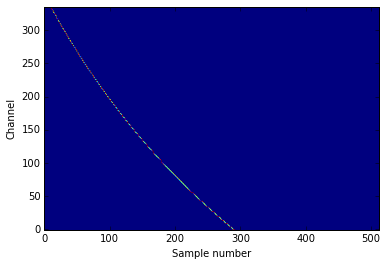

In [146]:
import simfrb # in same directory as fdmt

# I haven't had time to tidy this up - the untis are funny and the FRB is updside down and transposed
# With respect to what the FDMT wants to see - just trust me OK.
# Caution: The DM units here are in pc/cm3 and the DM units the FDMT uses are in samples. at about 1 GHz and 1 ms these are almost identical.
frb = simfrb.mkfrb(fmax/1e3, -df/1e3, nf, tsamp=tsamp, dm=200, ntimes=nt, offset=10).T
frb = np.flipud(frb)

#frb = frb/frb.sum(axis=1)[:, None] # Normalise frequencies

print frb.shape, frb.sum()
assert not np.any(np.isnan(frb))
imshow(frb, aspect='auto', origin='lower')
xlabel('Sample number')
ylabel('Channel')

In [147]:
reload(fdmt)
print 'Fmin', fmin,'df',df, 'nf', nf, 'nd', nd, 'nt', nt
thefdmt = fdmt.Fdmt( fmin, df, nf, nd, nt) # make FDMT
fout = thefdmt(frb)

Fmin 1104.0 df 1.0 nf 336 nd 1024 nt 512


Hitting efficiency 0.8034108687477044 Maximum at t= 290 idt= 280 = 199.4879563537168 pc/cm3


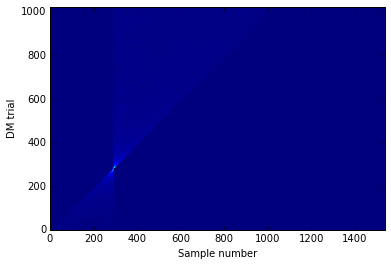

In [148]:
imshow(fout, origin='lower', aspect='auto')
hitting_efficiency = fout.max()/frb.sum() # should be close to 1. Ideally 1.
maxidx = fout.argmax()
idtmax, tmax = np.unravel_index(maxidx, fout.shape)
dm_of_idt = idtmax*tsamp/(4.15*((fmin/1e3)**-2 - (fmax/1e3)**-2)) # convert idt to pc/cm3
print 'Hitting efficiency', hitting_efficiency, 'Maximum at t=', tmax, 'idt=', idtmax, '=', dm_of_idt, 'pc/cm3'
xlabel('Sample number')
ylabel('DM trial')

(200, 400)

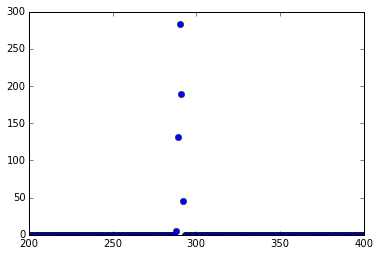

In [149]:
plot(fout[idtmax, :], 'o')
xlim(200,400)

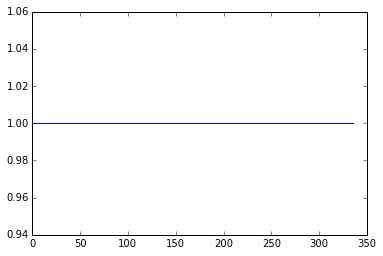

In [141]:
plot(np.sum(frb, axis=1))